# Анализ пространственных данных. Домашнее задание №2

Мягкий дедлайн: __4 ноября 2020 г. 23:59__

Жесткий дедлайн (со штрафом в _50%_ от количества набранных вами за ДЗ баллов): __5 ноября 2020 г. 08:59__

Визуализация "чего-либо" __без__ выполненного основного задания оценивается в __0 баллов__

ФИО: `Юрченко Петр Олегович`

Группа: `MADE-DS-11`

In [1]:
import osmapi as osm
from PIL import Image
import requests
from io import BytesIO
import random
import math as ma
import folium


import matplotlib.pyplot as plt
%matplotlib inline
import geopandas as gpd
import haversine as hs

from OSMPythonTools.nominatim import Nominatim
from OSMPythonTools.overpass import overpassQueryBuilder, Overpass

from rtree import index
from rtree.index import Rtree
import os
from folium import Map, Marker, LayerControl

from openrouteservice import client

import fiona as fn
from shapely import geometry
from shapely.geometry import shape, Polygon, mapping, MultiPolygon, LineString, Point
from shapely.ops import cascaded_union, transform

import pyproj
from pyproj import Transformer

## Задание №1. Горячая точка (алгоритм - 10 баллов, визуализация - 10 баллов).

Генерируйте рандомные точки на планете Земля до тех пор, пока не попадете на территорию ``Афганистана``

1. Вы можете использовать функции принадлжености точки полигону и расстояния от точки до полигона (в метрах)
2. Предложите не наивный алгоритм поиска (генерировать __напрямую__ точку из полигона границ Афганистана __запрещено__)

Не сразу увидел пометку про Folium, поэтому сделал 2 картинки. Если ячейка с генерированием точек на карте запустилась не с первого раза, она запустится со второго)

__Алгоритм:__

   - Выбираем первую точку start_point случайно на планете (на карте изображена зеленым цветом)
   - Считаем расстояние до центра Афганистана - dist
   - Следующую точку выбираем уже из окружности радиусом (dist + диаметр Афганистана) и центром в start_point
   - Если расстояние до Афганистана уменьшилось, то принимаем эту точку за start_point и повторяем, пока не придем в искомую страну (если выбираем точку, красим в синий цвет, если нет - в серый)
   - Финальная точка покрашена в желтый
   
   
__Почему я не использую Haversine__:

Haversine принимает на вход градусы, но, если мы пользуемся картой в crs 4326, то получаем следующие сообщения после некоторых операций: `UserWarning: Geometry is in a geographic CRS. Results from 'operation' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.`. Чтобы избежать грязи в коде и обойти возможные ошибки, я использую crs 3035. При этом уже не получается считать Haversine и приходится обходиться функцией .distance, но на качество решения это никак не влияет. (можете не сомневаться, что я умею считать Haversine distance) :)

In [2]:
world1 = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world1.to_crs('EPSG:3035') #3035 4326 32632

In [8]:
#minx, miny, maxx, maxy
bounds = world.total_bounds
bounds1 = world1.total_bounds

In [4]:
afghanistan = world[world.name == 'Afghanistan'].reset_index()
afg_poly = afghanistan.geometry
afg_center = afghanistan.centroid

In [5]:
afg_bounds = afghanistan.total_bounds
bottom_left = gpd.GeoSeries(Point(afg_bounds[0], afg_bounds[1]), crs=3035)
top_right = gpd.GeoSeries(Point(afg_bounds[2], afg_bounds[3]), crs=3035)
afg_diam = bottom_left.distance(top_right).values[0] / 100

In [11]:
def make_random_point_in_world(bounds):
    while True:
        rand_x = random.uniform(bounds[0] + 1, bounds[2] - 1)
        rand_y = random.uniform(bounds[1] + 1, bounds[3] - 1)
        point = gpd.GeoSeries(Point(rand_x, rand_y), crs=3035)
        check = point.to_crs('EPSG:4326').values[0]
        if (bounds[0] < rand_x < bounds[2]) and (bounds[1] < rand_y < bounds[3]):
            if (bounds1[0] < check.x < bounds1[2]) and (bounds1[1] < check.y < bounds1[3]):
                break
    return point

def make_random_point_in_circle(center, radius):
    while True:
        phi = 2 * ma.pi * random.uniform(0, 1)
        rand_x = radius * ma.cos(phi) + center[0]
        rand_y = radius * ma.sin(phi) + center[1]
        point = gpd.GeoSeries(Point(rand_x, rand_y), crs=3035)
        check = point.to_crs('EPSG:4326').values[0]
        if (bounds[0] < rand_x < bounds[2]) and (bounds[1] < rand_y < bounds[3]):
            if (bounds1[0] < check.x < bounds1[2]) and (bounds1[1] < check.y < bounds1[3]):
                break
    return point

Algotithm has convereged for 9 iterations


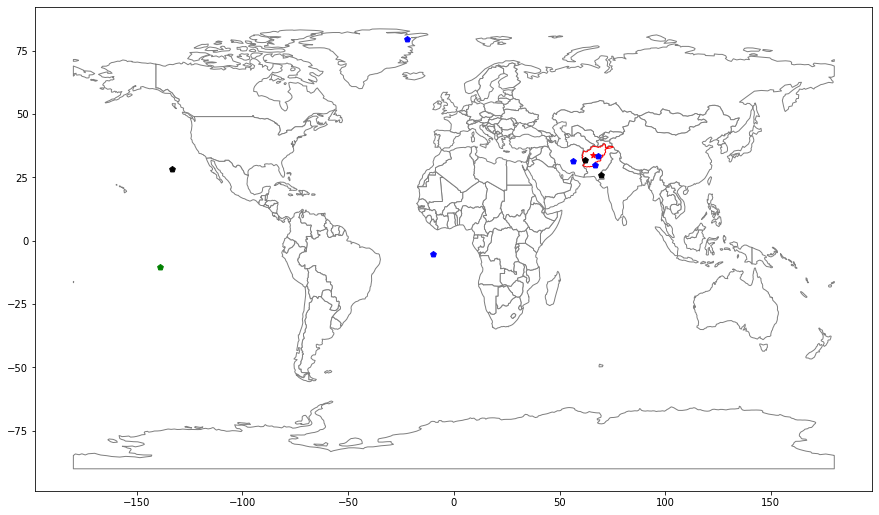

In [13]:
ax = world1.plot(color='white', edgecolor='grey', figsize=(15, 25))
afghanistan.to_crs('EPSG:4326').plot(ax=ax, color='white', edgecolor='red')
afg_center.to_crs('EPSG:4326').plot(ax=ax, color='red', marker='*')

start_point = make_random_point_in_world(bounds)
start_point.to_crs('EPSG:4326').plot(ax=ax, color='green', marker='p')
dist = afg_center.distance(start_point).values[0]
i = 1
while True:
    if afg_poly.contains(start_point).values[0]:
        break
    new_point = make_random_point_in_circle((start_point.values[0].x, start_point.values[0].y), dist + afg_diam)
    new_dist = afg_center.distance(new_point).values[0]
    if new_dist < dist:
        start_point = new_point
        dist = new_dist
        new_point.to_crs('EPSG:4326').plot(ax=ax, color='blue', marker='p')
    else:
        new_point.to_crs('EPSG:4326').plot(ax=ax, color='black', marker='p')
    i += 1

print(f'Algotithm has convereged for {i} iterations')
plt.show()

In [14]:
overpass = Overpass()
nominatim = Nominatim()
afgId = nominatim.query('Afghanistan').areaId()

In [15]:
query = overpassQueryBuilder(area=afgId, elementType='rel', selector="'name:en'='Afghanistan'", includeGeometry=True)

result = overpass.query(query)
result = result.elements()[0].geometry()['coordinates']

In [16]:
poly = []
for i in range(len(result)):
    ans = []
    for j in range(len(result[i])):
        ans.append([result[i][j][1], result[i][j][0]])
    poly.append(ans)

In [21]:
m = folium.Map(location=[33.807, 66.226],
              zoom_start = 2)

folium.Polygon(
    locations=poly,
    popup='Afganistan',
    color='red').add_to(m)

folium.CircleMarker(
    location=[33.807, 66.226],
    popup='Afganistan',
    color='crimson',
    fill=False,
    radius=2).add_to(m)


start_point = make_random_point_in_world(bounds)
to_plot = start_point.to_crs('EPSG:4326').values[0]

folium.CircleMarker(
    location=[to_plot.y, to_plot.x],
    popup='Initial Point',
    color='green',
    fill=False,
    radius=4).add_to(m)

dist = afg_center.distance(start_point).values[0]
i = 1
while True:
    if afg_poly.contains(start_point).values[0]:
        break
    new_point = make_random_point_in_circle((start_point.values[0].x, start_point.values[0].y), dist + afg_diam)
    new_dist = afg_center.distance(new_point).values[0]
    if new_dist < dist:
        start_point = new_point
        dist = new_dist
        to_plot = new_point.to_crs('EPSG:4326').values[0]
        folium.CircleMarker(
            location=[to_plot.y, to_plot.x],
            popup=f'{i}',
            color='blue',
            fill=False,
            radius=3).add_to(m)
    else:
        to_plot = new_point.to_crs('EPSG:4326').values[0]
        folium.CircleMarker(
            location=[to_plot.y, to_plot.x],
            popup=f'{i}',
            color='grey',
            fill=False,
            radius=3).add_to(m)
    i += 1
folium.CircleMarker(
            location=[to_plot.y, to_plot.x],
            popup='Final Point',
            color='yellow',
            fill=False,
            radius=5).add_to(m)

print(f'Algotithm has convereged for {i} iterations')
m

Algotithm has convereged for 9 iterations


Визуализируйте пошагово предложенный алгоритм при помощи ``Folium``

## Задание №2. Качество жизни (20 баллов).

Для измерения показателя качества жизни в точке, найденной в предыдущем задании, вам необходимо рассчитать следующую сумму расстояний (в метрах):

1. Расстояние от точки до 5 ближайших __*__ банкоматов, находящихся в стране с наибольшим количеством объектов жилой недвижимости
2. Расстояние от точки до 5 ближайших школ, находящихся в стране с наибольшим количеством аптек в столице
3. Расстояние от точки до 5 ближайших кинотеатров, наодящихся в стране с самым большим отношением числа железнодорожных станций к автобусным остановкам в южной части __**__

__*__ При поиске _N_ ближайших объектов обязательно использовать ``R-tree``

__**__ Южной частью страны является территория, находящаяся к югу от множества точек, равноудаленных от самой северной и самой южной точек страны

#### Наша точка

In [22]:
hot_point = (to_plot.x, to_plot.y, to_plot.x, to_plot.y)
print(to_plot)

POINT (67.98921889317425 36.30883199106739)


In [23]:
overpass = Overpass()
nominatim = Nominatim()

In [24]:
result = overpass.query('node["place" = "country"];out;')

In [25]:
list_of_countries = [a.tag('name:en') for a in result.elements()]

In [26]:
ids = []
for name in list_of_countries:
    id_ = nominatim.query(name).areaId()
    if id_ and id_ % 10 == 0:
        ids.append([id_, name])

### Пункт 1

In [27]:
living_objects_list = []
max_living_objects = 0
max_id = 0
for areaId, name in ids:
    query = overpassQueryBuilder(area=areaId, elementType=['node', 'way', 'rel'], selector="'building'='house'", out='count')
    result1 = overpass.query(query, timeout=500)
    query = overpassQueryBuilder(area=areaId, elementType=['node', 'way', 'rel'], selector="'building'='apartments'", out='count')
    result2 = overpass.query(query, timeout=500)
    living_objects = result1.countElements() + result2.countElements()
    #query = overpassQueryBuilder(area=areaId, elementType=['node', 'way', 'rel'], selector='"building"="residential"', out='count')
    #result = overpass.query(query, timeout=500)
    #living_objects = result.countElements()
    living_objects_list.append([areaId, living_objects])
    print(f'There are {living_objects} living objects in "{name}" with areaId = {areaId}')
    if living_objects > max_living_objects:
        max_living_objects = living_objects
        max_id = areaId

There are 3768 living objects in "Comoros" with areaId = 3600535790
There are 107 living objects in "São Tomé and Príncipe" with areaId = 3600535880
There are 1299 living objects in "Sint Maarten (Netherlands)" with areaId = 3601231790
There are 179504 living objects in "Norway" with areaId = 3602978650
There are 32029 living objects in "Honduras" with areaId = 3600287670
There are 3178 living objects in "Eswatini" with areaId = 3600088210
There are 11233 living objects in "Liberia" with areaId = 3600192780
There are 44747 living objects in "Malawi" with areaId = 3600195290
There are 12557 living objects in "Syria" with areaId = 3600184840
There are 20945 living objects in "Azerbaijan" with areaId = 3600364110
There are 645525 living objects in "Brazil" with areaId = 3600059470
There are 7394 living objects in "Estonia" with areaId = 3600079510
There are 61954 living objects in "Tanzania" with areaId = 3600195270
There are 507696 living objects in "Australia" with areaId = 3600080500
T

__Видим, что интересующая нас страна - Бразилия__

In [28]:
# Чтобы не скачивать информацию по недвижимости со всех стран:
# max_id = 3600059470

query = overpassQueryBuilder(area=max_id, elementType='node', selector="'amenity'='atm'", out='meta', includeGeometry=True)
result = overpass.query(query, timeout=60)

In [29]:
idx = Rtree()
for i, elt in enumerate(result.elements()):
    coords = elt.geometry()['coordinates']
    idx.add(i, tuple(coords + coords), obj=coords)

In [30]:
nearest_atms = [(a.id, a.object) for a in idx.nearest(hot_point, 5, objects=True)]
nearest_atms

[(335, [-32.410944, -3.840601]),
 (336, [-32.410996, -3.841433]),
 (343, [-32.425885, -3.849353]),
 (337, [-32.428587, -3.856503]),
 (338, [-32.428589, -3.856536])]

__Мы нашли ближайшие 5 банкоматов, теперь посчитаем расстояние от нашей точки до них:__

In [31]:
distances = []
for i, coords in nearest_atms:
    dist = hs.haversine(coords, [to_plot.x, to_plot.y])
    distances.append(dist)

In [32]:
print(f'Distances for nearest ATMs in Brazil are {[round(d,2) for d in distances]} km')
print(f'Average dist is equal to {round(sum(distances)/5, 2)} km')

Distances for nearest ATMs in Brazil are [11650.81, 11650.84, 11652.63, 11653.09, 11653.09] km
Average dist is equal to 11652.09 km


In [33]:
m = folium.Map(location=[to_plot.y, to_plot.x],
              zoom_start = 2)

folium.CircleMarker(
        location=[to_plot.y, to_plot.x],
        popup='Hot Point',
        color='red',
        fill=False,
        radius=3).add_to(m)


for i, coords in nearest_atms:
    folium.Marker(
        location=[coords[1], coords[0]],
        popup='ATM').add_to(m)
m

### Пункт 2

In [34]:
ids2 = []
for elt in ids:
    elt1 = elt.copy()
    query = overpassQueryBuilder(area=elt[0], elementType=['node'], selector="'capital'='yes'", out='meta')
    result = overpass.query(query, timeout=60)
    if len(result.elements()) > 0:
        capital = result.elements()[0].tag('name:en')
        elt1.append(capital)
    else:
        elt1.append('')
    id_ = nominatim.query(capital).areaId()
        
    elt1.insert(0, id_)
    if elt1[2] == 'Australia':
        elt1[0] = 3602354197
    if elt1[2] == 'Brazil':
        elt1[0] = 3602758138
    ids2.append(elt1)

In [35]:
ids2

[[3600198859, 3600535790, 'Comoros', 'Moroni'],
 [3600198859, 3600535880, 'São Tomé and Príncipe', ''],
 [3600198859, 3601231790, 'Sint Maarten (Netherlands)', ''],
 [3600406091, 3602978650, 'Norway', 'Oslo'],
 [3603850824, 3600287670, 'Honduras', 'Tegucigalpa'],
 [None, 3600088210, 'Eswatini', 'Mbabane'],
 [3609319970, 3600192780, 'Liberia', 'Monrovia'],
 [3607345524, 3600195290, 'Malawi', 'Lilongwe'],
 [3600186228, 3600184840, 'Syria', 'Damascus'],
 [3603764541, 3600364110, 'Azerbaijan', 'Baku'],
 [3602758138, 3600059470, 'Brazil', 'Brasília'],
 [3602164745, 3600079510, 'Estonia', 'Tallinn'],
 [3601600774, 3600195270, 'Tanzania', 'Dodoma'],
 [3602354197, 3600080500, 'Australia', 'Canberra'],
 [3602746229, 3600192830, 'Cameroon', 'Yaounde'],
 [3602216724, 3600196240, 'Uzbekistan', 'Tashkent'],
 [3602805426, 3600536900, 'Antigua and Barbuda', "St. John's"],
 [3610249594, 3600184640, 'Bangladesh', 'Dhaka'],
 [3607322726, 3600192790, 'Central African Republic', 'Bangui'],
 [3607322726, 3

In [36]:
pharmacy_list = []
max_pharmacy = 0
max_pharmacy_id = 0
for areaId, countryId, country, capital in ids2:
    if areaId:
        query = overpassQueryBuilder(area=areaId, elementType=['node', 'way'], selector="'amenity'='pharmacy'", out='count')
        result = overpass.query(query, timeout=500)
        pharmacy = result.countElements()
        pharmacy_list.append([areaId, capital, pharmacy])
        print(f'There are {pharmacy} pharmacy building in {capital}, {country} with areaId = {countryId}')
        if pharmacy > max_pharmacy:
            max_pharmacy = pharmacy
            max_pharmacy_id = countryId

There are 0 pharmacy building in Moroni, Comoros with areaId = 3600535790
There are 0 pharmacy building in , São Tomé and Príncipe with areaId = 3600535880
There are 0 pharmacy building in , Sint Maarten (Netherlands) with areaId = 3601231790
There are 129 pharmacy building in Oslo, Norway with areaId = 3602978650
There are 161 pharmacy building in Tegucigalpa, Honduras with areaId = 3600287670
There are 3 pharmacy building in Monrovia, Liberia with areaId = 3600192780
There are 10 pharmacy building in Lilongwe, Malawi with areaId = 3600195290
There are 2 pharmacy building in Damascus, Syria with areaId = 3600184840
There are 243 pharmacy building in Baku, Azerbaijan with areaId = 3600364110
There are 123 pharmacy building in Brasília, Brazil with areaId = 3600059470
There are 82 pharmacy building in Tallinn, Estonia with areaId = 3600079510
There are 20 pharmacy building in Dodoma, Tanzania with areaId = 3600195270
There are 46 pharmacy building in Canberra, Australia with areaId = 36

__На этот раз побеждает Ташкент, Узбекистан__

Не забываем, что ищем школы в стране, а не в столице

In [37]:
# Чтобы не скачивать информацию по аптекам со всех стран:
# max_pharmacy_id = 3600196240

query = overpassQueryBuilder(area=max_pharmacy_id, elementType='node', selector="'amenity'='school'", out='meta', includeGeometry=True)
result = overpass.query(query, timeout=60)

In [38]:
idx2 = Rtree()
for i, elt in enumerate(result.elements()):
    coords = elt.geometry()['coordinates']
    idx2.add(i, tuple(coords + coords), obj=coords)

In [39]:
nearest_schools = [(a.id, a.object) for a in idx2.nearest(hot_point, 5, objects=True)]
nearest_schools

[(343, [67.276189, 37.238506]),
 (274, [67.112056, 37.484092]),
 (538, [67.599956, 37.830305]),
 (537, [67.602234, 37.835019]),
 (370, [66.918341, 37.936266])]

In [40]:
distances2 = []
for i, coords in nearest_schools:
    dist = hs.haversine(coords, [to_plot.x, to_plot.y])
    distances2.append(dist)

In [41]:
print(f'Distances for nearest schools in Uzbekistan are {[round(d,2) for d in distances2]} km')
print(f'Average dist is equal to {round(sum(distances2)/5, 2)} km')

Distances for nearest schools in Uzbekistan are [88.51, 109.56, 77.21, 77.23, 137.81] km
Average dist is equal to 98.06 km


In [57]:
m = folium.Map(location=[to_plot.y, to_plot.x],
              zoom_start = 5)

folium.CircleMarker(
        location=[to_plot.y, to_plot.x],
        popup='Hot Point',
        color='red',
        fill=False,
        radius=3).add_to(m)


for i, coords in nearest_schools:
    folium.Marker(
        location=[coords[1], coords[0]],
        popup='School').add_to(m)
m

### Пункт 3

In [43]:
def take_poly_by_id(id_, name):
    query = overpassQueryBuilder(area=id_, elementType='rel', selector=f"'name:en'='{name}'", includeGeometry=True)
    area_result = overpass.query(query, timeout=60)
    if area_result.elements():
        area = area_result.elements()[0].geometry()['coordinates']
    else:
        area = [[[]]]
    return area

In [44]:
def make_south_polygon(id_, name):
    area = take_poly_by_id(id_, name)
    if area == [[[]]]:
        return {'polygon': None, 'params':None}
    poly = []
    lower_point = [0, 95]
    upper_point = [0, -95]
    for i in range(len(area)):
        for j in range(len(area[i])):
            if len(area[i][j]) > 2:
                for k in range(len(area[i][j])):
                    if area[i][j][k][1] < lower_point[1]:
                        lower_point = [area[i][j][k][0], area[i][j][k][1]]
                    if area[i][j][k][1] > upper_point[1]:
                        upper_point = [area[i][j][k][0], area[i][j][k][1]]
            else:
                if area[i][j][1] < lower_point[1]:
                    lower_point = [area[i][j][0], area[i][j][1]]
                if area[i][j][1] > upper_point[1]:
                    upper_point = [area[i][j][0], area[i][j][1]]

    x_c = (lower_point[0] + upper_point[0]) / 2
    y_c = (lower_point[1] + upper_point[1]) / 2
    k_c = - (lower_point[0] - upper_point[0]) / (lower_point[1] - upper_point[1])
    # y = k_c * x + (y_c - k_c * x_c)

    for i in range(len(area)):
        ans1 = []
        for j in range(len(area[i])):
            if len(area[i][j]) > 2:
                ans2 = []
                for k in range(len(area[i][j])):
                    if area[i][j][k][1] <= k_c * area[i][j][k][0] + (y_c - k_c * x_c):
                        ans2.append([area[i][j][k][1], area[i][j][k][0]])
                if len(ans2) > 1:
                    ans1.append(ans2)
                else:
                    ans1 += ans2
            else:
                if area[i][j][1] <= k_c * area[i][j][0] + (y_c - k_c * x_c):
                    ans1.append([area[i][j][1], area[i][j][0]])
        if len(ans1) > 1:
            poly.append(ans1)
        else:
            poly += ans1
    return {'polygon':poly, 'params':[x_c, y_c, k_c], 'lower':lower_point, 'upper':upper_point}

__Проверим, что это првильно работает:__

In [45]:
a = make_south_polygon(3600059470, 'Brazil')
poly_ = a['polygon']
x_c, y_c, k = a['params']
lower_point, upper_point = a['lower'], a['upper']

m = folium.Map(location=[y_c, x_c],
              zoom_start = 4)

folium.Polygon(
    locations=poly_,
    popup='Brazil',
    color='red').add_to(m)

folium.Marker(
    location=[lower_point[1], lower_point[0]],
    popup='Lower Point').add_to(m)
folium.Marker(
    location=[upper_point[1], upper_point[0]],
    popup='Upper Point').add_to(m)

m

In [46]:
def ratio_between_railway_and_bus_stations(areaId, name):
    a = make_south_polygon(areaId, name)
    if a['params'] == None:
        return 0
    x_c, y_c, k_c = a['params']
    bus_query = overpassQueryBuilder(area=areaId, elementType=['node', 'way'], selector="'highway'='bus_stop'", out='meta')
    railway_query = overpassQueryBuilder(area=areaId, elementType=['node', 'way'], selector="'railway'='station'", out='meta')
    bus_result = overpass.query(bus_query, timeout=1000)
    railway_result = overpass.query(railway_query, timeout=1000)
    
    bus_cnt, railway_cnt = 0, 0
    if bus_result.nodes():
        for bus_stop in bus_result.nodes():
            coords = bus_stop.geometry()['coordinates']
            if coords[1] <= k_c * coords[0] + (y_c - k_c * x_c):
                bus_cnt += 1
    if bus_result.ways():
        for bus_stop in bus_result.ways():
            coords = bus_stop.nodes()[0].geometry()['coordinates']
            if coords[1] <= k_c * coords[0] + (y_c - k_c * x_c):
                bus_cnt += 1

    if railway_result.nodes():
        for railway_station in railway_result.nodes():
            coords = railway_station.geometry()['coordinates']
            if coords[1] <= k_c * coords[0] + (y_c - k_c * x_c):
                railway_cnt += 1
    if railway_result.ways():
        for railway_station in railway_result.ways():
            coords = railway_station.nodes()[0].geometry()['coordinates']
            if coords[1] <= k_c * coords[0] + (y_c - k_c * x_c):
                railway_cnt += 1

    if bus_cnt == 0:
        return 0
    return railway_cnt / bus_cnt

In [47]:
ratios = []
max_ratio = 0
max_ratio_id = 0
for areaId, country in ids:
    ratio = ratio_between_railway_and_bus_stations(areaId, country)
    ratios.append([areaId, country, ratio])
    print(f'The ratio between railway and bus stations is {round(ratio, 3)} in {country} with areaId = {areaId}')
    if ratio > max_ratio:
        max_ratio = ratio
        max_ratio_id = areaId

The ratio between railway and bus stations is 0.0 in Comoros with areaId = 3600535790
The ratio between railway and bus stations is 0.0 in São Tomé and Príncipe with areaId = 3600535880
The ratio between railway and bus stations is 0 in Sint Maarten (Netherlands) with areaId = 3601231790
The ratio between railway and bus stations is 0.003 in Norway with areaId = 3602978650
The ratio between railway and bus stations is 0.012 in Honduras with areaId = 3600287670
The ratio between railway and bus stations is 0.0 in Eswatini with areaId = 3600088210
The ratio between railway and bus stations is 0 in Liberia with areaId = 3600192780
The ratio between railway and bus stations is 0.522 in Malawi with areaId = 3600195290
The ratio between railway and bus stations is 0.292 in Syria with areaId = 3600184840
The ratio between railway and bus stations is 0.238 in Azerbaijan with areaId = 3600364110
The ratio between railway and bus stations is 0.019 in Brazil with areaId = 3600059470
The ratio bet

__Отношение искомых показателей максимально в южной части Центральноафриканской Республики__

In [48]:
# Чтобы не скачивать информацию со всех стран:
# max_ratio_id = 3600192790

query = overpassQueryBuilder(area=max_ratio_id, elementType=['node', 'way', 'rel'], selector="'amenity'='cinema'", out='meta')
result = overpass.query(query, timeout=60)

Данная Республика имеет всего 3 кинотеатра

In [49]:
idx3 = Rtree()
for i, elt in enumerate(result.nodes()):
    coords = elt.geometry()['coordinates']
    idx3.add(i, tuple(coords + coords), obj=coords)

for i, elt in enumerate(result.ways()):
    coords = elt.nodes()[0].geometry()['coordinates']
    idx3.add(i+len(result.nodes()), tuple(coords + coords), obj=coords)

In [50]:
nearest_cinemas = [(a.id, a.object) for a in idx3.nearest(hot_point, 5, objects=True)]
nearest_cinemas

[(0, [20.667211, 5.762733]),
 (2, [17.035418, 6.704233]),
 (1, [15.194631, 4.772817])]

In [51]:
distances3 = []
for i, coords in nearest_cinemas:
    dist = hs.haversine(coords, [to_plot.x, to_plot.y])
    distances3.append(dist)

In [52]:
print(f'Distances for nearest cinemas in Central African Republic are {[round(d,2) for d in distances3]} km')
print(f'Average dist is equal to {round(sum(distances3)/3, 2)} km')

Distances for nearest cinemas in Central African Republic are [5671.83, 6040.82, 6287.7] km
Average dist is equal to 6000.12 km


In [59]:
m = folium.Map(location=[to_plot.y, to_plot.x],
              zoom_start = 3)

folium.CircleMarker(
        location=[to_plot.y, to_plot.x],
        popup='Hot Point',
        color='red',
        fill=False,
        radius=3).add_to(m)


for i, coords in nearest_cinemas:
    folium.Marker(
        location=[coords[1], coords[0]],
        popup='School').add_to(m)
m

## Задание №3. Поездка по Нью-Йорку (маршрут - 20 баллов, визуализация - 10 баллов).

Добраться __на автомобиле__ от входа в ``Central Park`` __Нью-Йорка__ (со стороны ``5th Avenue``) до пересечения ``Water Street`` и ``Washington Street`` в Бруклине (откуда получаются лучшие фото Манхэттенского моста) довольно непросто - разумеется, из-за вечных пробок. Однако еще сложнее это сделать, проезжая мимо школ, где дети то и дело переходят дорогу в неположенном месте.

Вам необходимо построить описанный выше маршрут, избегая на своем пути школы. Визуализируйте данный маршрут (также добавив школы и недоступные для проезда участки дорог) при помощи ``Folium``

Данные о расположении школ Нью-Йорка можно найти [здесь](https://catalog.data.gov/dataset/2019-2020-school-point-locations)

In [60]:
api_key = '5b3ce3597851110001cf624894df21d7d939457bb091965ee1b87ea3' 
clnt = client.Client(key=api_key)
url = 'https://data.cityofnewyork.us/api/views/a3nt-yts4/rows.json?accessType=DOWNLOAD'
schools = requests.get(url).json()

In [61]:
def parse_schools(data):
    list_of_school_coords = []
    for school in schools['data']:
        x = float(school[8].split()[1][1:])
        y = float(school[8].split()[2][:-1])
        list_of_school_coords.append([x, y])
    return list_of_school_coords

In [62]:
data = parse_schools(schools)

In [69]:
def CreateBufferPolygon(point_in, resolution=2, radius=30):    
    #sr_wgs = pyproj.Proj('epsg:4326') # WGS84
    #sr_utm = pyproj.Proj('epsg:32632') # UTM32N
    transformer = Transformer.from_crs('epsg:4326', 'epsg:32632', always_xy=True)
    point_in_proj = transformer.transform(*point_in) 
    point_buffer_proj = Point(point_in_proj).buffer(radius, resolution=resolution)
    
    poly_wgs = []
    transformer2 = Transformer.from_crs('epsg:32632', 'epsg:4326', always_xy=True)
    for point in point_buffer_proj.exterior.coords:
        poly_wgs.append(transformer2.transform(*point)) # Transform back to WGS84
        
    return poly_wgs


# Function to request directions with avoided_polygon feature
def CreateRoute(avoided_point_list, n=0):
    route_request = {'coordinates': coordinates, 
                    'format_out': 'geojson',
                    'profile': 'driving-car',
                    'preference': 'shortest',
                    'instructions': False,
                     'options': {'avoid_polygons': geometry.mapping(MultiPolygon(avoided_point_list))}} 
    route_directions = clnt.directions(**route_request)
    
    return route_directions


# Function to create buffer around requested route
def CreateBuffer(route_directions): 
    line_tup = []
    for line in route_directions['features'][0]['geometry']['coordinates']:
        tup_format = tuple(line)
        line_tup.append(tup_format)  

    new_linestring = LineString(line_tup)
    dilated_route = new_linestring.buffer(0.001)
        
    return dilated_route

In [74]:
school_map = folium.Map( location=([40.73418, -73.98139]), zoom_start=12) #tiles='Stamen Toner',

def style_function(color):
    return lambda feature: dict(color=color)

counter = 0
school_list = []
school_polygons = []
for point in data:
    if -74.1342 < point[0] < -73.8635 and 40.68 < point[1] < 40.8:
        folium.Marker(list(reversed(point)),
                  icon=folium.Icon(color='lightblue',
                                icon_color='brown',
                                icon='briefcase',
                                prefix='fa'),
                  popup='school').add_to(school_map)

        school = CreateBufferPolygon(point,
                                       resolution=2,
                                       radius=150)
        
        school_list.append(school)
        poly = Polygon(school)  
        school_polygons.append(poly)

union_poly = mapping(cascaded_union(school_polygons)) 
                      
folium.features.GeoJson(data=union_poly,
                        name='All schools',
                        style_function=style_function('#ffd699'),).add_to(school_map)

school_map

In [75]:
coordinates = [[-73.97319, 40.76514], [-73.98959, 40.70322]]
for coord in coordinates:
    folium.Marker(list(reversed(coord)), 
                     icon=folium.Icon(color='red',
                                     icon_color='white',
                                     popup='Route Points')).add_to(school_map)

avoided_point_list = [] 
route_directions = CreateRoute(avoided_point_list) 

folium.features.GeoJson(data=route_directions,
                        name='Regular Route',
                        style_function=style_function('#ff5050'),
                        overlay=True).add_to(school_map)


dilated_route = CreateBuffer(route_directions)

try:
    for site_poly in school_list:
        poly = Polygon(site_poly)
        if poly.within(dilated_route):
            avoided_point_list.append(poly)

            route_directions = CreateRoute(avoided_point_list, 1)
            dilated_route = CreateBuffer(route_directions)

    folium.features.GeoJson(data=route_directions,
                            name='Alternative Route',
                            style_function=style_function('#006600'),
                            overlay=True).add_to(school_map)

except Exception: 
    print('Sorry, there is no route available between the requested destination because of too many blocked streets.')
school_map.add_child(folium.map.LayerControl())
school_map